In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats

plt.style.use('default')

Often in neuroscience we try to model brain responses based on some features of input stimuli. For example, consider an experiment in which we measure the reaction time (y) when participants are presented with stimuli of different color (1: red, 2: green, 3: blue) and shape (1: circles, 2: squares) over 100 trials. Our reaction times can be modeled as follows:

$$ y = FU + \epsilon $$

Where $ y \sim \mathcal{N}(FU, \sigma^2 I) $  is a random vector:

<Axes: xlabel='colour', ylabel='RT'>

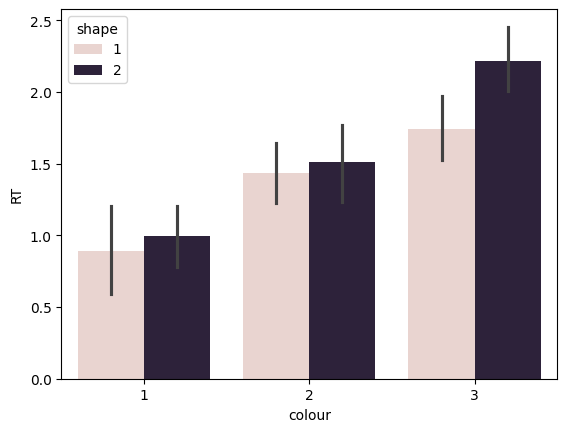

In [30]:
# Define parameters
num_trials = 100  # Number of trials
num_features = 2  # Two stimulus features: shape and color
sigma = 0.5  # Noise standard deviation
num_shapes = 2
num_colors = 3

np.random.seed(42)

# Generate random shape (1 or 2) and color (1, 2, or 3) for each trial
shapes = np.random.randint(1, num_shapes + 1, size=num_trials)
colors = np.random.randint(1, num_colors + 1, size=num_trials)

# Construct F matrix where each row corresponds to a trial
F = np.column_stack((shapes, colors))  # Shape in column 1, Color in column 2

# Define true U (how shape and color affect reaction time)
U = np.array([0.3, 0.5])  # Shape contributes 0.3s, color 0.5s

# Compute the mean of y: FU
mean_y = F @ U

# Generate the random vector y with Gaussian noise
y = mean_y + np.random.normal(0, sigma, num_trials)

df = pd.DataFrame({'RT': y, 'shape': F[:, 0], 'colour': F[:, 1]})

# sort trials by color and shape
df.sort_values(by=['colour', 'shape'], inplace=True)
y = df['RT'].to_numpy()
F = df[['colour', 'shape']].to_numpy()

sns.barplot(data=df, x='colour', hue='shape', y='RT')

Because of how we constructed $F$ and $U$, our reaction times are influenced by the colour of the stimuli and (to a lesser extent) by their shape. But suppose $y$ contains experimental data and we want to estimate how much each feature influences the data. To do this, we can design a new feature matrix $F$ knowing which color and shape were presented in each trial and then find the set of $ \hat{U}$ weights that minimize the reconstruction error (e.g. using the Ordinary Least Square approach):

In [31]:
# estimate U_hat using OLS
lambda_ridge = 1e-2
U_hat = np.linalg.pinv(F.T @ F) @ F.T @ y

Now, we can derive a statistic to determine whether our $\hat{U}$ weights reflect a significant relationship between features and data, e.g., a t-statistic:

In [32]:
# Compute y_hat
y_hat = F @ U_hat

# Compute residuals
residuals = y - y_hat

# Estimate variance of residuals (σ^2)
N, p = F.shape  # Number of trials (N) and number of features (p)
sigma_hat_squared = np.sum(residuals**2) / (N - p)

# Compute standard error of U_hat
cov_matrix_U_hat = sigma_hat_squared * np.linalg.pinv(F.T @ F)  # Covariance matrix of U_hat
SE_U_hat = np.sqrt(np.diag(cov_matrix_U_hat))  # Standard error of each coefficient

# Compute t-statistic for each feature
t_stat = U_hat / SE_U_hat

# Compute p-values from t-distribution (two-tailed test)
p_values = 2 * (1 - stats.t.cdf(np.abs(t_stat), df=N - p))

# Display results
df_t_stats = pd.DataFrame({
    "Feature": ["Shape", "Color"],
    "U_hat": U_hat,
    "Standard Error": SE_U_hat,
    "t-Statistic": t_stat,
    "p-Value": p_values
})

print(df_t_stats)

  Feature     U_hat  Standard Error  t-Statistic   p-Value
0   Shape  0.540646        0.047313    11.427081  0.000000
1   Color  0.254108        0.063975     3.972008  0.000136


Both our weights are significantly larger than 0 (i.e., both p-Values <0.05) which indicates that both features influence the reaction time in this experiment. This means that the reaction time contains information about (or encodes) these two features, which can be linearly decoded from it, once we know the weights. Yet, this is not the end of the story. Indeed, colour and shape are not the only two features that predict accurately our reaction time. Any rotation $Fr$ of these features obtained by multiplying them by an orthonormal matrix $R$ such that $RR^T = I$ can predict the data equally well using a different set of $\hat{Ur}$ weights:

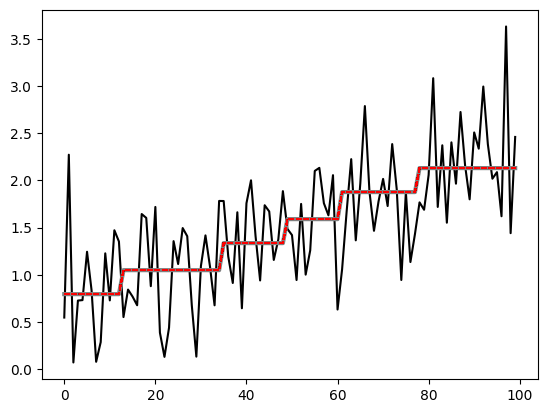

In [33]:
num_iterations = 100

U_hat_r = np.zeros((num_iterations, num_features))
y_hat_r = np.zeros((num_iterations, num_trials))
for i in range(100):

    # Define orthonormal matrix R
    R, _ = np.linalg.qr(np.random.randn(num_features, num_features))

    # Rotate F
    Fr = F @ R

    # estimate U_hat using OLS
    U_hat_r[i] = np.linalg.pinv(Fr.T @ Fr) @ Fr.T @ y

    y_hat_r[i] = Fr @ U_hat_r[i]

plt.plot(y, color='k')
plt.plot(y_hat, color='grey', lw=3)
plt.plot(y_hat_r.T, color='red', lw=1,ls='--')

The black line shows the original data. The thick grey line shows the predicted data using the original $F$ matrix with colour and shape as features. The red dashed line(s) shows the predicted data using 100 rotated version of $F$. Yes, there are 100 lines piled onto each other in the image, perfectly overlapping y_hat! These 100 sets of arbitrary features predict perfectly the data using the different sets of $U$ weights plotted below. The grey dot shows the original set of weights (i.e., 0.3 and 0.5):

Text(0, 0.5, 'Shape')

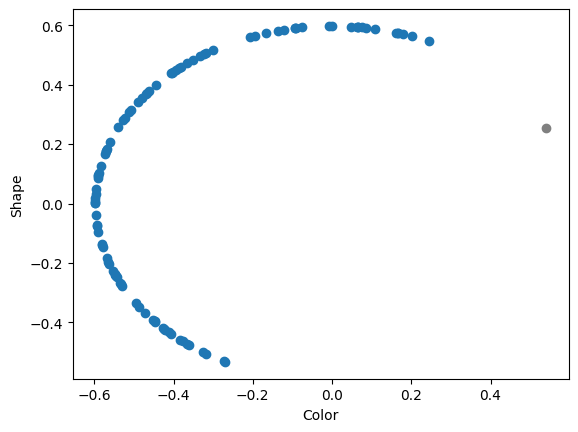

In [34]:
plt.scatter(U_hat_r[:, 0], U_hat_r[:, 1])
plt.scatter(U_hat[0], U_hat[1], color='grey')
plt.xlabel('Color')
plt.ylabel('Shape')

Why all these arbitrary feature sets can explain equally well the data and what do they have in common? The answer is simple, they share the same **Second Moment Matrix** $FF^T$:

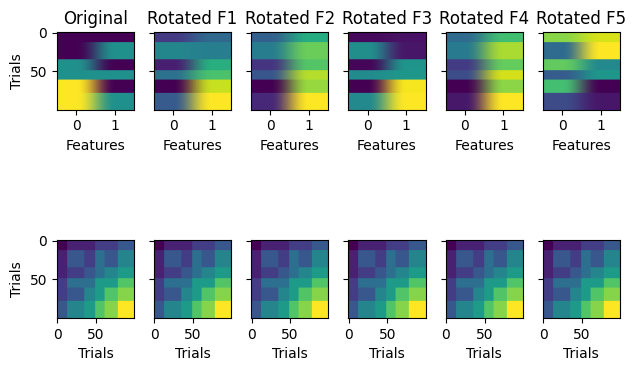

In [35]:
# compute original G
G_obs = F @ F.T / F.shape[1]

num_iterations = 5
fig, axs = plt.subplots(2, num_iterations+1, sharey=True, sharex='row')

axs[0, 0].imshow(F)
axs[1, 0].imshow(G_obs)

axs[0, 0].set_ylabel('Trials')
axs[0, 0].set_xlabel('Features')
axs[1, 0].set_xlabel('Trials')
axs[1, 0].set_ylabel('Trials')
axs[0, 0].set_title('Original')

for i in range(num_iterations):

    # Define orthonormal matrix R
    R, _ = np.linalg.qr(np.random.randn(num_features, num_features))

    # Rotate F
    Fr = F @ R

    # Compute Gr
    Gr = Fr @ Fr.T / Fr.shape[1]

    # plot
    axs[0, i+1].imshow(Fr)
    axs[1, i+1].imshow(Gr)

    axs[1, i+1].set_xlabel('Trials')
    axs[0, i+1].set_xlabel('Features')
    axs[0, i+1].set_title(f'Rotated F{i+1}')

for ax in axs.flat:
    ax.set_box_aspect(1)  # Keep square aspect ratio
    ax.set_aspect('auto')  # Allow aspect ratio to adapt but preserve width

fig.tight_layout()

In the figure above, the rotated feature matrices (first row) maintain the same second moment matrix (second row). Instead of using an arbitrary set of features and fitting weights to the data (like we did above using OLS and similar to what is done in encoding models), in PCM we compute the **marginal likelihood** of the data under any possible $U$ given a **second moment matrix $FF^T$**. What do we mean by "any possible $U$"? The second moment of the observed data $y$ is:

$$G_{y}=yy^T$$

Which can be expressed as:

$$ G_{y} = FU(FU)^T $$
$$ G_{y} = FUU^TF^T $$
$$ G_{y} = FG_{U}F^T $$

In theory, $G_{U}$, like we saw for $FF^T$ above, can be generated by infinite orthonormal transformations of $U$. Yet, for the relation $ G_{y} = FG_{U}F^T $ to hold, $U$ can only span a limited subspace as can be appreciated in cell 6. In other words, the **likelihood** of observing a certain $U$ is defined by the second moment matrix $FF^T$. PCM calculates the marginal likelihood of the data by integrating over the subspace of $U$ defined by $FF^T$:

$$ p(Y|\theta) = \int p(Y|U,\theta)p(U|\theta)dU $$

Where \theta are a set of parameters defining a (model) second moment matrix, p(U|\theta) is the probability of observing a certain set of weights $U$ given the parameters \theta , $ p(Y|U,\theta) $ is the probability of observing the data $Y$ given a $U$ and $\theta$ and $ p(Y|\theta)$ is the probability of observing $Y$ given $\theta$ after integrating over all the possible $U$. In particular, the parameters $\theta$ are estimated to maximize $ p(Y|\theta)$:

$$ \hat{\theta} =\arg\max_{\theta} p(Y|\theta)$$

Ok, enough theory, go to the pcm_hands_on notebook for an application example using real fMRI data!

